In [1]:
#
#* 데이터 경로 설정
root_dir = !pwd
root_dir = root_dir[0]
# !mkdir -p data_demo
# %cd data_demo
# !gdown 1wjuiVcO92Rqer5gLk-X7hINfe4PCMQmu
# !pip install tqdm
# !unzip -o 5LpN3gDmAk7_1.zip | tqdm --desc extracted --unit files --unit_scale --total `unzip -l 5LpN3gDmAk7_1.zip | tail -n 1 | xargs echo -n | cut -d' ' -f2` > /dev/null
# %cd ..
import os
#data_dir = "/home/hong/capstone/vlmaps/data_custom"
data_dir = os.path.join(root_dir, "Data/habitat_sim/", "2t7WUuJeko7_2_mini")
version = "dbscanning2"
#
#* 갖고있는 depth, rgb 이미지를 이용해 비디오로 시각화해주는 작업
#* 단순 시각화용일 뿐이며, VLMaps 제작이나 이후 작업에 사용되지는 않음
# @title Helper functions for video creation and display
import sys
import os
import imageio
import numpy as np
import cv2
import tqdm
from IPython.display import HTML
from base64 import b64encode

# @markdown if the colab instance doesn't have GPU, untick the following checkbox
has_gpu = True # @param {type: "boolean"}
codec = "h264"
if has_gpu:
  codec = "h264_nvenc"

def load_depth(depth_filepath):
    with open(depth_filepath, 'rb') as f:
        depth = np.load(f)
    return depth


In [2]:
#
#* setup VLMaps parameters
# @markdown meters per cell size
cs = 0.025 # @param {type: "number"} #* 셀 크기 당 미터 단위
# @markdown map resolution (gs x gs)
gs = 2000 # @param {type: "integer"} #* 맵의 해상도 (그리드 수 _ 정수 단위)
# @markdown camera height (used for filtering out points on the floor)
camera_height = 1.5 # @param {type: "number"} #* 카메라 높이 (바닥에 있는 점을 필터링하는 데 사용)
# @markdown depth pixels subsample rate
depth_sample_rate = 10 # @param {type: "integer"} #* depth 정보의 픽셀 sampling rate
# @markdown data where rgb, depth, pose are loaded and map are saved
data_dir = data_dir # @param {type: "string"} #* 데이터 경로

In [3]:
%matplotlib inline
import os
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from utils.mapping_utils import load_map, get_new_pallete, get_new_mask_pallete
from utils.clip_utils import get_text_feats
from utils.matterport3d_categories import mp3dcat #* 여기엔 그 장애물이 리스트 형태로 저장되어있음
import clip

In [4]:
use_self_built_map = True # @param {type: "boolean"} 
map_save_dir = os.path.join(data_dir, "map")
if use_self_built_map:
    map_save_dir = os.path.join(data_dir, f"map/2t7WUuJeko7_2_mini_{version}")
os.makedirs(map_save_dir, exist_ok=True)

color_top_down_save_path = os.path.join(map_save_dir, f"color_top_down_{version}.npy")
grid_save_path = os.path.join(map_save_dir, f"grid_{version}.npy")
obstacles_save_path = os.path.join(map_save_dir, f"obstacles_{version}.npy")
weight_save_path = os.path.join(map_save_dir, f"weight_{version}.npy")
background_grid_save_path = os.path.join(map_save_dir, f"background_grid_{version}.npy")
# gt_save_path = os.path.join(map_save_dir, f"grid_lseg_gt.npy")
print(data_dir)


/nvme0n1/hong/VLMAPS/InstanceSeemMap/Data/habitat_sim/2t7WUuJeko7_2_mini


[0 1]


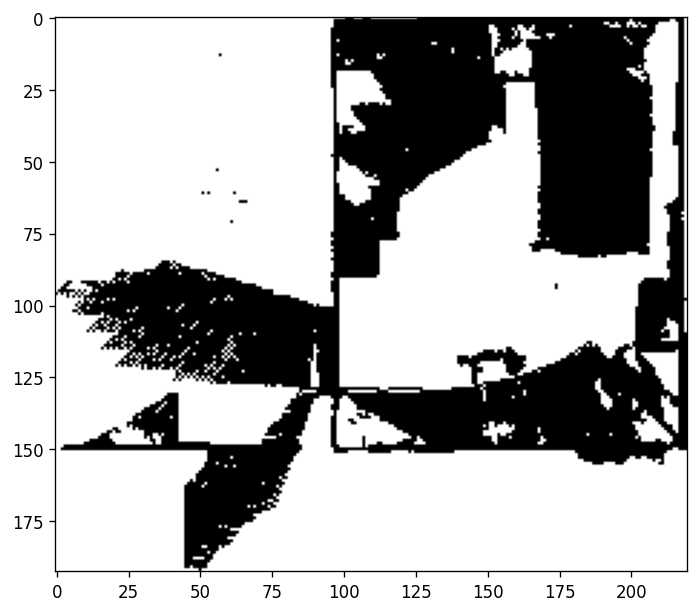

In [5]:
obstacles = load_map(obstacles_save_path)
color_top_down = load_map(color_top_down_save_path)
x_indices, y_indices = np.where(obstacles == 0)

xmin = np.min(x_indices)
xmax = np.max(x_indices)
ymin = np.min(y_indices)
ymax = np.max(y_indices)

print(np.unique(obstacles))
obstacles_pil = Image.fromarray(obstacles[xmin:xmax+1, ymin:ymax+1])
plt.figure(figsize=(8, 6), dpi=120)
plt.imshow(obstacles_pil, cmap='gray')
plt.show()

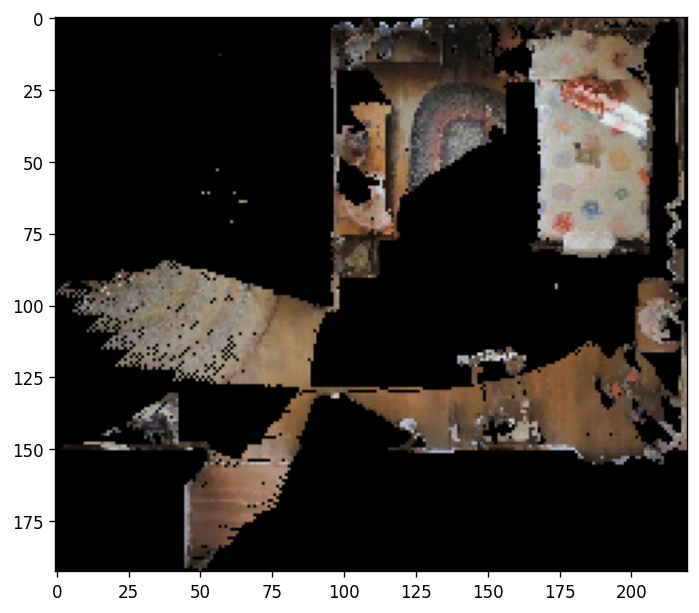

In [6]:
color_top_down = load_map(color_top_down_save_path)
color_top_down = color_top_down[xmin:xmax+1, ymin:ymax+1]
color_top_down_pil = Image.fromarray(color_top_down)
plt.figure(figsize=(8, 6), dpi=120)
plt.imshow(color_top_down_pil)
plt.show()


In [7]:
%%capture
import torch
device = "cuda" if torch.cuda.is_available() else "cpu"

In [8]:
grid = load_map(grid_save_path)
print(grid.shape)
grid = grid[xmin:xmax+1, ymin:ymax+1]
print(grid.shape)
print(grid_save_path)
print(grid[100,100].keys())

(2000, 2000)
(193, 220)
/nvme0n1/hong/VLMAPS/InstanceSeemMap/Data/habitat_sim/2t7WUuJeko7_2_mini/map/2t7WUuJeko7_2_mini_dbscanning/grid_dbscanning.npy
dict_keys([])


In [9]:
background_grid = load_map(background_grid_save_path)
background_grid = background_grid[xmin:xmax+1, ymin:ymax+1]
print(background_grid.shape)
bbackground_grid = np.zeros_like(background_grid)
bbackground_grid[background_grid == 1] = 2
bbackground_grid[background_grid == 2] = 1

(193, 220, 512)


In [10]:
from seem.base_model import build_vl_model
model = build_vl_model("seem", input_size = 360)

[*] model loaded


In [11]:
# query = ["void","table in the kitchen"]
query = [
    "void",
    "wall",
    "floor",
    "chair",
    "door",
    "table",
    "picture",
    "cabinet",
    "cushion",
    "window",
    "sofa",
    "bed",
    "curtain",
    "chest_of_drawers",
    "plant",
    "sink",
    "stairs",
    "ceiling",
    "toilet",
    "stool",
    "towel",
    "mirror",
    "tv_monitor",
    "shower",
    "column",
    "bathtub",
    "counter",
    "fireplace",
    "lighting",
    "beam",
    "railing",
    "shelving",
    "blinds",
    "gym_equipment",
    "seating",
    "board_panel",
    "furniture",
    "appliances",
    "clothes",
    "objects",
    # "carpet"
]
# query = [
#     "void",
#     "wall",
#     "floor",
#     "chair",
#     "door",
#     "table",
#     "picture",
#     "cabinet",
#     "cushion",
#     "window",
#     "sofa",
#     "bed",
#     "curtain",
#     "sink",
#     "stairs"
# ]

# query = [
#     "void",
# #    "floor",
#     "bed_room in a scene"
# ]
t_emb = model.encode_prompt(query, task="default")

aa = t_emb.cpu().numpy()
print(aa.shape)

# query = ["table","computer"]
# t_emb = model.encode_prompt(query, task="default")
# aa = t_emb.cpu().numpy()

# print(aa.shape)

# qq = ["computer on the table"]
# tt = model.encode_prompt(qq, task="default")
# bb = tt.cpu().numpy()



(40, 512)


In [12]:
import pickle

embeddings_path = os.path.join(map_save_dir, f"instance_dict_{version}.pkl")

print(embeddings_path)



#"/home/hong/VLMAPS/vlseem/Data/habitat/vlmaps_dataset/2t7WUuJeko7_2_mini/map/instance_dict_dummy_geo_dist4.pkl"

with open(embeddings_path, 'rb') as f:
    embeddings = pickle.load(f)

no_map_mask = obstacles[xmin:xmax+1, ymin:ymax+1] > 0

/nvme0n1/hong/VLMAPS/InstanceSeemMap/Data/habitat_sim/2t7WUuJeko7_2_mini/map/2t7WUuJeko7_2_mini_dbscanning/instance_dict_dbscanning.pkl


(193, 220)
embeddings: 25


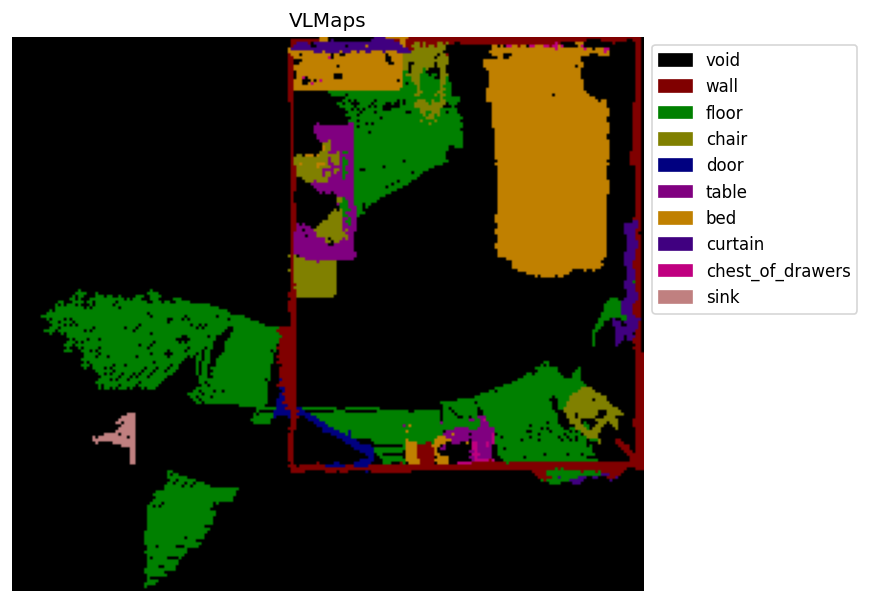

In [13]:
no_map_mask = obstacles[xmin:xmax+1, ymin:ymax+1] > 0
print(grid.shape)
id_list = []
instance_feat = []
print("embeddings:",len(embeddings.keys()))
# print(embeddings.keys())
# print("grid:",grid.shape)
ids=[]
for i in range(grid.shape[0]):
    for j in range(grid.shape[1]):
        for arg in grid[i,j].keys():
            if arg not in ids:
                ids.append(arg)

# np.set_printoptions(threshold=np.inf)
# print(ids)
# print("grid ids:",len(ids))
# print(grid)
# print(embeddings)
for id, val in embeddings.items():
    id_list.append(id)
    instance_feat.append(val["embedding"])
instance_feat = np.array(instance_feat)

# instance_feat = np.vstack([aa[:2,:],instance_feat])

# print("instance_feat:",instance_feat.shape)
scores_list = instance_feat @ aa.T
# print("scores_list:",scores_list)
# key_list = list(embeddings.keys())
# print(key_list)
# print(scores_list.shape)
predicts = np.argmax(scores_list, axis=1)
ggrid_map = np.zeros((grid.shape[0], grid.shape[1]), dtype=int)
# ggrid_map[background_grid == 1] = 2
# ggrid_map[background_grid == 2] = 1
for i in range(grid.shape[0]):
    for j in range(grid.shape[1]):
        if len(grid[i,j].keys()) == 0:
            continue
        if len(grid[i,j].keys()) == 1:
            # print(grid[i,j][0])
            for key in grid[i,j].keys():
                # if key in [1,0]:
                #     ggrid_map[i,j]=key
                #     continue
                ggrid_map[i,j] = predicts[list(embeddings.keys()).index(key)]
        else:
            max_conf = 0
            max_height = 50000
            max_observed = 0
            for key, val in grid[i,j].items():
                # print(arg)
                # print(predicts.shape)
                # if key in [1,0]: continue
                candidate = predicts[list(embeddings.keys()).index(key)]
                candidate_conf = val[0]
                candidate_height = val[1]
                candidate_observed = val[2]
                # if max_conf < candidate_conf:
                #     max_conf = candidate_conf
                #     candidate_val = candidate
                # if max_height > candidate_height:
                #     max_height = candidate_height
                #     candidate_val = candidate
                if candidate_observed > max_observed:
                    max_observed = candidate_observed
                    candidate_val = candidate
            ggrid_map[i,j] = candidate_val
floor_mask = ggrid_map == 2
# print("ggrid_map",ggrid_map.shape)
new_pallete = get_new_pallete(len(query))
mask, patches = get_new_mask_pallete(ggrid_map, new_pallete, out_label_flag=True, labels=query)
seg = mask.convert("RGBA")
seg = np.array(seg)
# seg[no_map_mask] = [225, 225, 225, 255]
# seg[floor_mask] = [225, 225, 225, 255]
seg = Image.fromarray(seg)



# ggrid_map_save_path = os.path.join(map_save_dir, f"ggrid_{mask_version}.npy")
# np.save(ggrid_map_save_path, ggrid_map)

plt.figure(figsize=(10, 6), dpi=120)
plt.legend(handles=patches, loc='upper left', bbox_to_anchor=(1., 1), prop={'size': 10})
plt.axis('off')
plt.title("VLMaps")
plt.imshow(seg)
plt.show()

(193, 220)
embeddings: 25


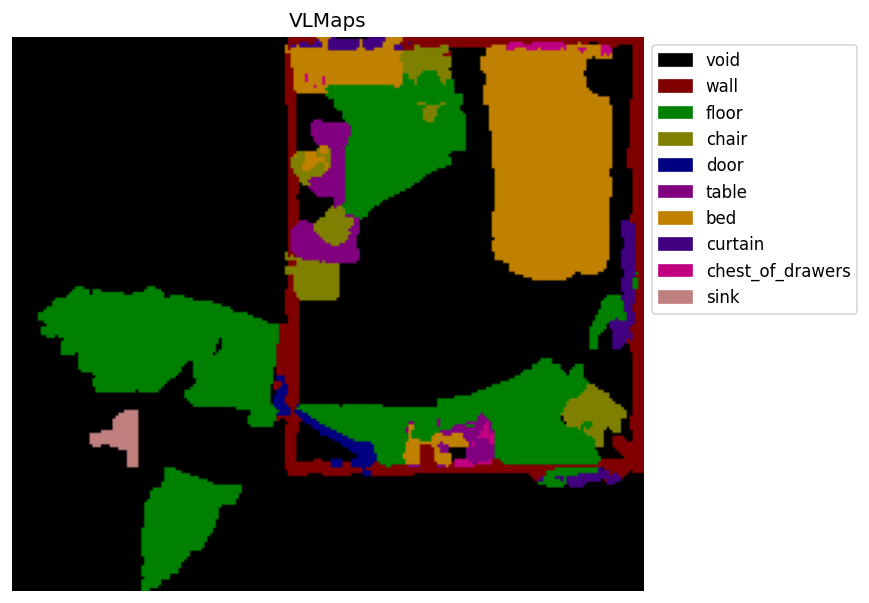

In [14]:
no_map_mask = obstacles[xmin:xmax+1, ymin:ymax+1] > 0
print(grid.shape)
id_list = []
instance_feat = []
print("embeddings:",len(embeddings.keys()))
# print(embeddings.keys())
# print("grid:",grid.shape)
ids=[]
for i in range(grid.shape[0]):
    for j in range(grid.shape[1]):
        for arg in grid[i,j].keys():
            if arg not in ids:
                ids.append(arg)

# np.set_printoptions(threshold=np.inf)
# print(ids)
# print("grid ids:",len(ids))
# print(grid)
# print(embeddings)
for id, val in embeddings.items():
    id_list.append(id)
    instance_feat.append(val["embedding"])
instance_feat = np.array(instance_feat)
# print("instance_feat:",instance_feat.shape)
scores_list = instance_feat @ aa.T
# print("scores_list:",scores_list)
# key_list = list(embeddings.keys())
# print(key_list)
# print(scores_list.shape)
predicts = np.argmax(scores_list, axis=1)
ggrid_map = np.empty_like(grid, dtype=dict)
for i in range(grid.shape[0]):
    for j in range(grid.shape[1]):
        ggrid_map[i,j] = {}
        
for i in range(grid.shape[0]):
    for j in range(grid.shape[1]):
        if len(grid[i,j].keys()) == 0:
            continue
        # if len(grid[i,j].keys()) == 1:
        #     # print(grid[i,j][0])
        for key in grid[i,j].keys():
            new_key = predicts[list(embeddings.keys()).index(key)]
            ggrid_map[i,j][new_key] = grid[i,j][key][2]
                # ggrid_map[i,j] = predicts[list(embeddings.keys()).index(key)]
        # else:
        #     max_conf = 0
        #     max_height = 0
        #     # candidate_val = 0
        #     for key, val in grid[i,j].items():
        #         # print(arg)
        #         # print(predicts.shape)
        #         candidate = predicts[list(embeddings.keys()).index(key)]
        #         candidate_conf = val[0]
        #         candidate_height = val[2]
        #         # if max_conf < candidate_conf:
        #         #     max_conf = candidate_conf
        #         #     candidate_val = candidate
        #         if max_height < candidate_height:
        #             max_height = candidate_height
        #             candidate_val = candidate
        #     ggrid_map[i,j] = candidate_val

center_weight = 3
gggrid_map = np.zeros_like(ggrid_map, dtype=np.uint8)
grid_upper = np.empty((ggrid_map.shape[0]+1, ggrid_map.shape[1]+1), dtype=dict)
for i in range(ggrid_map.shape[0]+1):
    for j in range(ggrid_map.shape[1]+1):
        grid_upper[i,j] = {}
grid_upper[1:,1:] = ggrid_map
for i in range(1,gggrid_map.shape[0]+1):
    for j in range(1,gggrid_map.shape[1]+1):
        candidate = grid_upper[i-1:i+2,j-1:j+2]
        item_dict = {}
        for candidate_i in range(candidate.shape[0]):
            for candidate_j in range(candidate.shape[1]):
                if candidate_i == i and candidate_j == j:
                    # if len(candidate[candidate_i,candidate_j]) == 0: continue
                    for key, val in candidate[candidate_i,candidate_j].items():
                        if key in item_dict.keys():
                            item_dict[key] += center_weight #* val
                        else: item_dict[key] = center_weight #* val
                else:
                    # if len(candidate[candidate_i,candidate_j]) == 0: continue
                    for key, val in candidate[candidate_i,candidate_j].items():
                        if key in item_dict.keys():
                            item_dict[key] += 1 #* val
                        else: item_dict[key] = 1 #*  val
        if len(item_dict) ==0:
            gggrid_map[i-1,j-1] = 0
            continue
        max_key = max(item_dict, key=item_dict.get)
        gggrid_map[i-1,j-1] = max_key


floor_mask = gggrid_map == 2
# print("ggrid_map",ggrid_map.shape)
new_pallete = get_new_pallete(len(query))
mask, patches = get_new_mask_pallete(gggrid_map, new_pallete, out_label_flag=True, labels=query)
seg = mask.convert("RGBA")
seg = np.array(seg)
# seg[no_map_mask] = [225, 225, 225, 255]
# seg[floor_mask] = [225, 225, 225, 255]
seg = Image.fromarray(seg)
plt.figure(figsize=(10, 6), dpi=120)
plt.legend(handles=patches, loc='upper left', bbox_to_anchor=(1., 1), prop={'size': 10})
plt.axis('off')
plt.title("VLMaps")
plt.imshow(seg)
plt.show()

dict_keys([0, 1, 2, 3, 4, 5, 6, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 28, 31])
wall
(193, 220)
1564


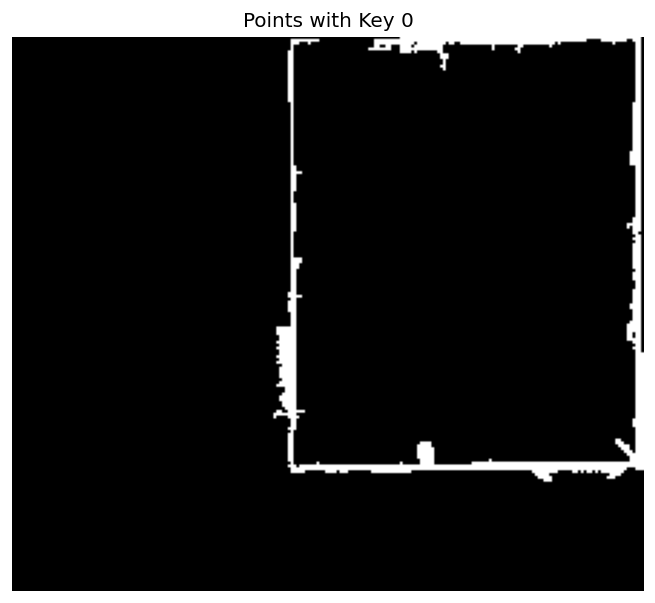

floor
(193, 220)
4107


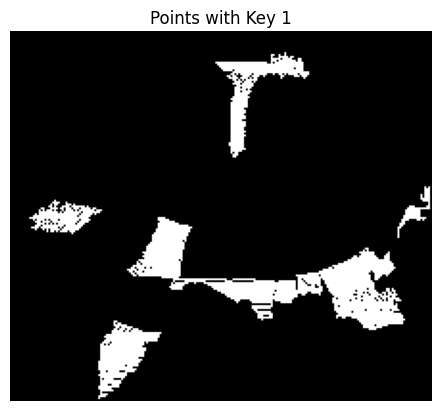

bed
(193, 220)
630


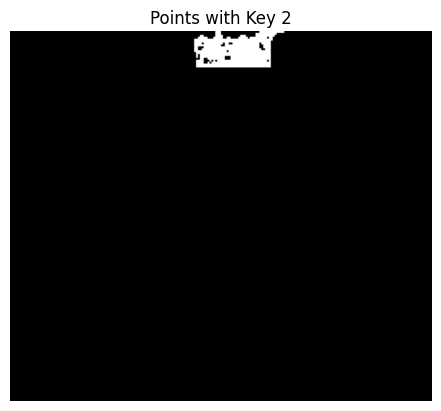

bed
(193, 220)
2962


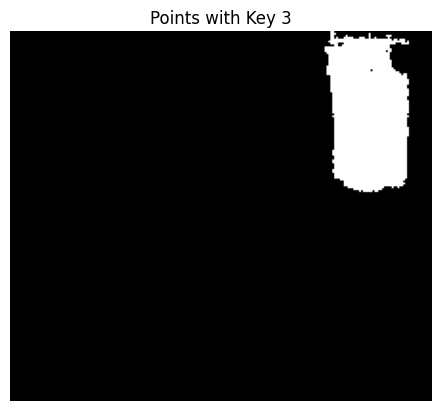

bed
(193, 220)
109


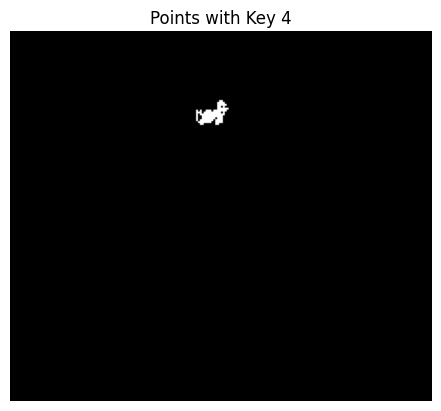

bed
(193, 220)
201


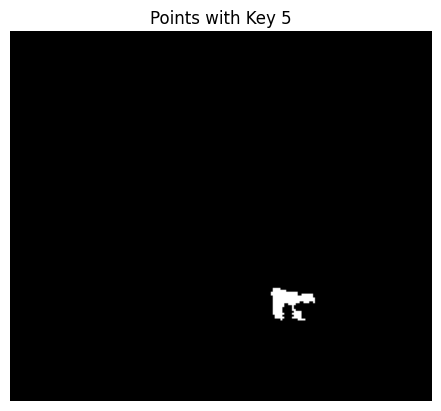

curtain
(193, 220)
239


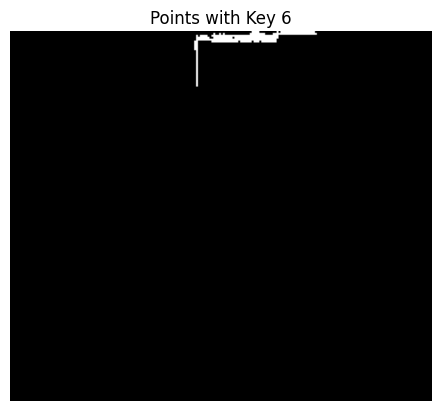

curtain
(193, 220)
259


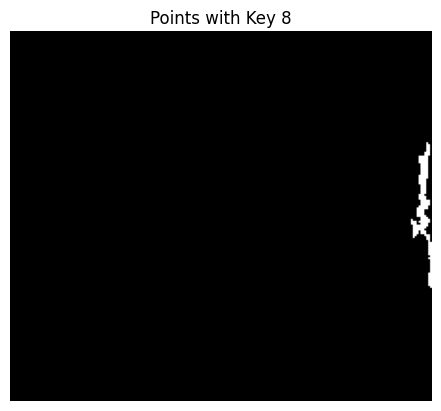

curtain
(193, 220)
101


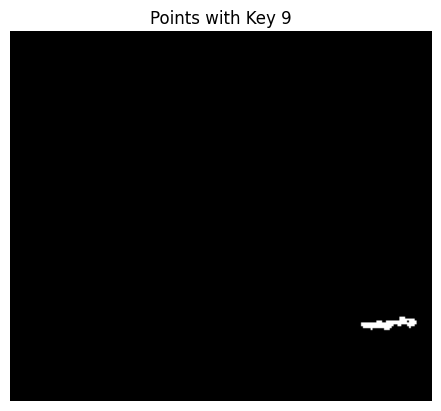

chair
(193, 220)
297


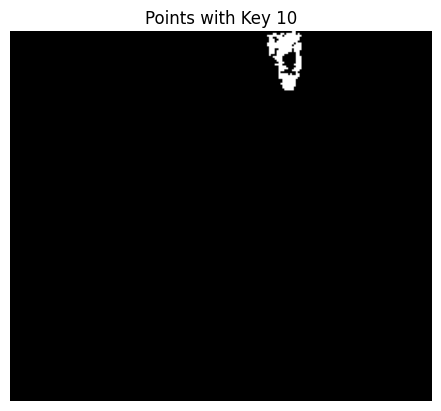

chair
(193, 220)
220


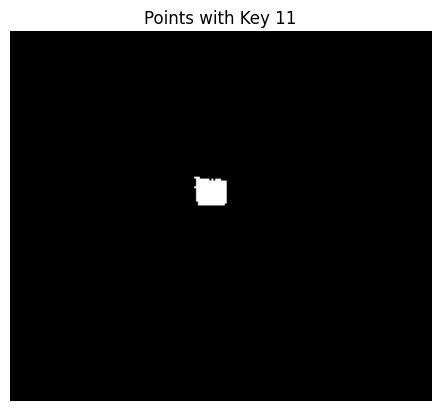

chair
(193, 220)
208


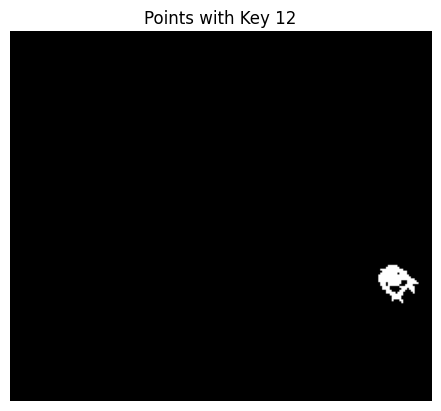

chest_of_drawers
(193, 220)
254


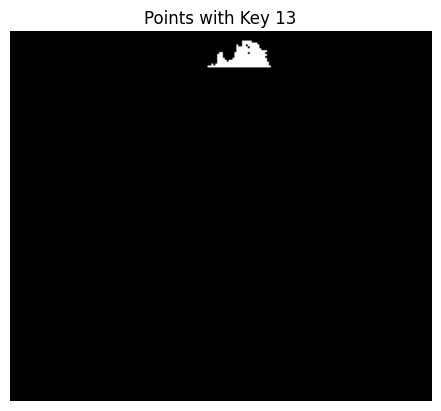

table
(193, 220)
585


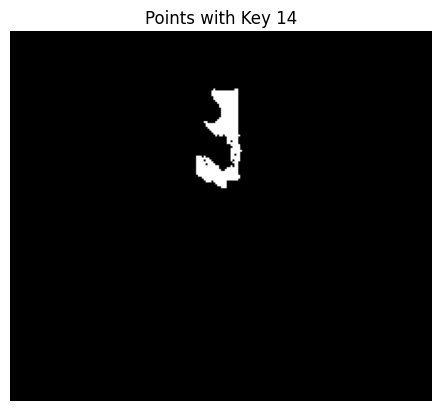

table
(193, 220)
412


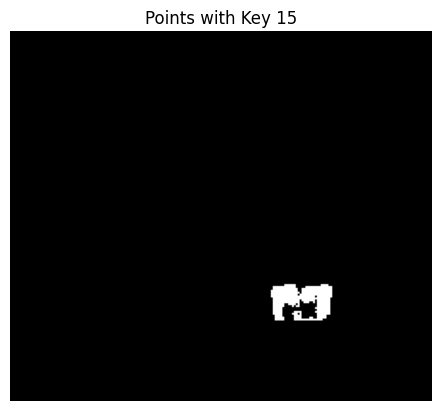

chest_of_drawers
(193, 220)
117


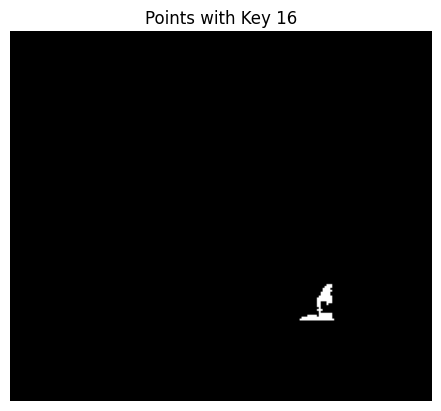

door
(193, 220)
227


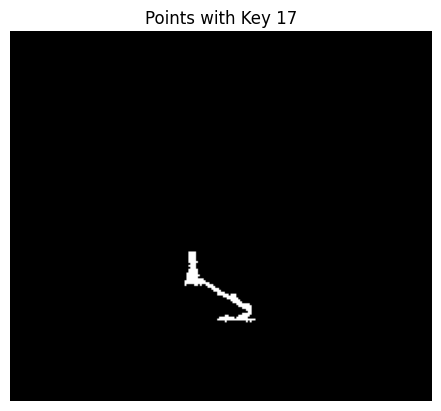

door
(193, 220)
127


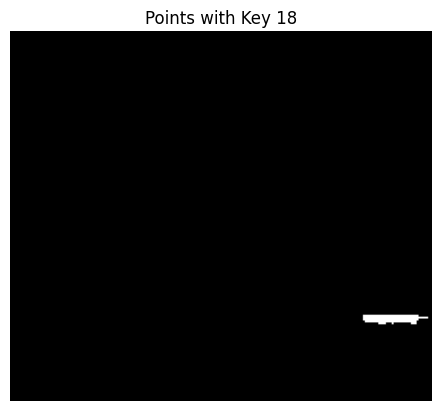

floor
(193, 220)
831


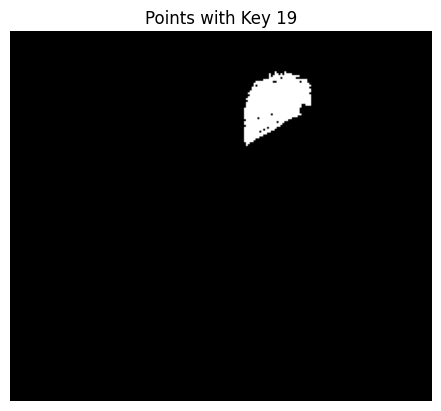

floor
(193, 220)
1183


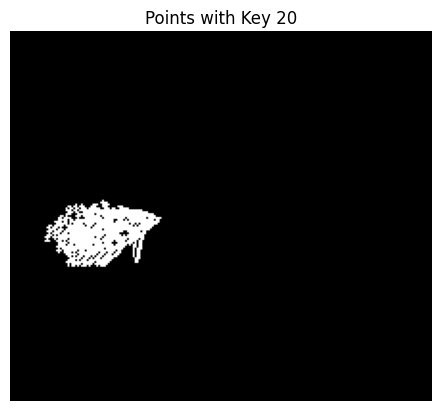

chair
(193, 220)
168


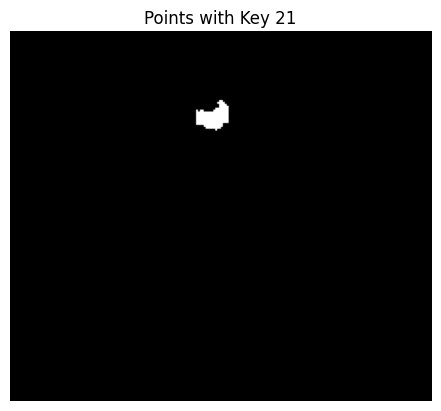

chest_of_drawers
(193, 220)
101


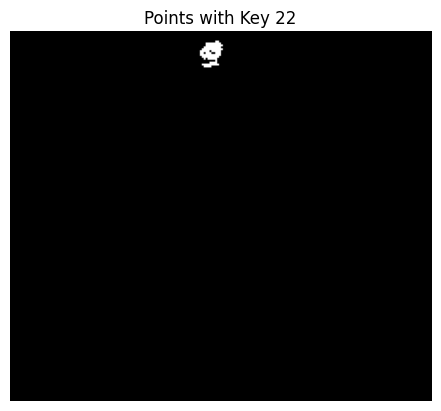

chair
(193, 220)
155


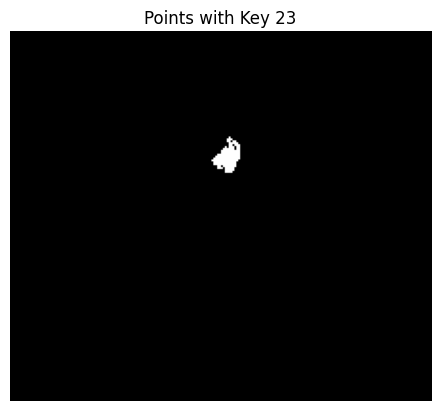

chest_of_drawers
(193, 220)
162


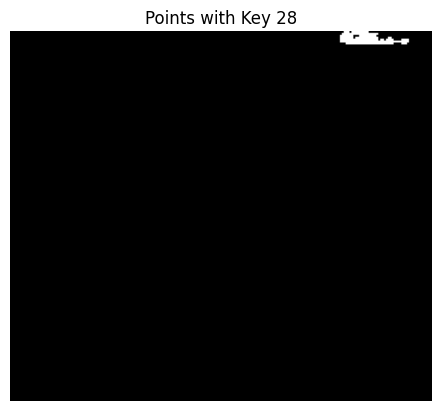

sink
(193, 220)
102


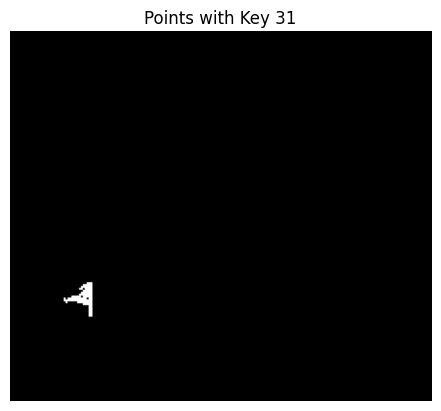

In [15]:
# # 좌표에 0이 키값으로 있는 포인트만 선택하여 ggrid_map 생성
# ggrid_map = np.zeros((grid.shape[0], grid.shape[1]), dtype=int)
# for i in range(grid.shape[0]):
#     for j in range(grid.shape[1]):
#         if 5 in grid[i, j]:
#             ggrid_map[i, j] = 1  # 0 키를 가진 포인트는 1로 표시

# # 시각화를 위해 1이 있는 곳만 표시
# plt.figure(figsize=(10, 6), dpi=120)
# plt.imshow(ggrid_map, cmap="gray")
# plt.axis('off')
# plt.title("Points with Key 0")
# plt.show()

import numpy as np
import matplotlib.pyplot as plt

# 시각화를 위한 설정
plt.figure(figsize=(10, 6), dpi=120)
print(embeddings.keys())
# k값을 0부터 287까지 변경하면서 시각화
for n,id in enumerate(embeddings.keys()):
    # 좌표에 k가 키값으로 있는 포인트만 선택하여 ggrid_map 생성
    ggrid_map = np.zeros((grid.shape[0], grid.shape[1]), dtype=int)
    for i in range(grid.shape[0]):
        for j in range(grid.shape[1]):
            if id in grid[i, j]:
                ggrid_map[i, j] = 1  # k 키를 가진 포인트는 1로 표시
    # maskk = embeddings[id]["mask"]
    # print(maskk.shape)
    # print(np.sum(maskk))
    # # 시각화를 위해 1이 있는 곳만 표시
    # plt.clf()  # 이전 이미지 지우기
    # plt.imshow(maskk, cmap="gray")

    plt.clf()  # 이전 이미지 지우기
    name = predicts[n]
    print(query[name])
    print(ggrid_map.shape)
    print(np.sum(ggrid_map))
    plt.imshow(ggrid_map, cmap="gray")


    plt.axis('off')
    plt.title(f"Points with Key {id}")
    plt.draw()  # 현재 상태를 그리기
    plt.pause(0.5)  # 0.5초 간격으로 업데이트 (시간 조정 가능)

    plt.show()
